# importing libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve, roc_curve, auc , precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# importing dataset 

In [2]:
data = pd.read_csv('Heart Disease.csv') 
print(data.head())

   male  age  education  currentSmoker  cigsPerDay  BPMeds  prevalentStroke  \
0     1   39        4.0              0         0.0     0.0                0   
1     0   46        2.0              0         0.0     0.0                0   
2     1   48        1.0              1        20.0     0.0                0   
3     0   61        3.0              1        30.0     0.0                0   
4     0   46        3.0              1        23.0     0.0                0   

   prevalentHyp  diabetes  totChol  sysBP  diaBP    BMI  heartRate  glucose  \
0             0         0    195.0  106.0   70.0  26.97       80.0     77.0   
1             0         0    250.0  121.0   81.0  28.73       95.0     76.0   
2             0         0    245.0  127.5   80.0  25.34       75.0     70.0   
3             1         0    225.0  150.0   95.0  28.58       65.0    103.0   
4             0         0    285.0  130.0   84.0  23.10       85.0     85.0   

   HeartDisease  
0             0  
1             

# check for null values 

In [3]:
print(data.shape)
print(data.isnull().sum())


(4238, 16)
male                 0
age                  0
education          105
currentSmoker        0
cigsPerDay          29
BPMeds              53
prevalentStroke      0
prevalentHyp         0
diabetes             0
totChol             50
sysBP                0
diaBP                0
BMI                 19
heartRate            1
glucose            388
HeartDisease         0
dtype: int64


# substituting the null with median

In [4]:
data.fillna(data.median(), inplace=True)  
print(data.isnull().sum())

male               0
age                0
education          0
currentSmoker      0
cigsPerDay         0
BPMeds             0
prevalentStroke    0
prevalentHyp       0
diabetes           0
totChol            0
sysBP              0
diaBP              0
BMI                0
heartRate          0
glucose            0
HeartDisease       0
dtype: int64


# Train-Val-Test Split

In [5]:
# split data in 70:15:15 without using sklearn library use data.sample or random function and storing a cop of data for further use in k fold cross validation
data_copy = data.copy() 
train_data = data.sample(frac=0.7, random_state=42)
test_data = data.drop(train_data.index)
val_data = test_data.sample(frac=0.5, random_state=42)
test_data = test_data.drop(val_data.index)

# split data in x and y
x_train = train_data.iloc[:, :-1]
y_train = train_data.iloc[:, -1]

x_test = test_data.iloc[:, :-1]
y_test = test_data.iloc[:, -1]

x_val = val_data.iloc[:, :-1]
y_val = val_data.iloc[:, -1]




# convert pd dataframe to numpy and upsample the 1 class due to class imbalance 

In [6]:

x_test_np = x_test.to_numpy()
y_test_np = y_test.to_numpy()
x_train_np = x_train.to_numpy()
y_train_np = y_train.to_numpy()
x_val_np = x_val.to_numpy()
y_val_np = y_val.to_numpy()
print(x_train_np)
print("Before Upsampling:")
print(pd.Series(y_train_np).value_counts())

# Separate the training set into two parts based on the labels
x_train_0 = x_train_np[y_train_np == 0]
y_train_0 = y_train_np[y_train_np == 0]

x_train_1 = x_train_np[y_train_np == 1]
y_train_1 = y_train_np[y_train_np == 1]

# Determine the number of samples needed to balance the classes
num_upsample = len(y_train_0) - len(y_train_1)

# Upsample the minority class (y == 1) using np.random.choice
if num_upsample > 0:
    indices = np.random.choice(len(x_train_1), num_upsample, replace=True)
    x_train_upsampled = np.concatenate((x_train_np, x_train_1[indices]), axis=0)
    y_train_upsampled = np.concatenate((y_train_np, y_train_1[indices]), axis=0)
else:
    x_train_upsampled = x_train_np
    y_train_upsampled = y_train_np

# Shuffle the upsampled dataset
shuffle_indices = np.random.permutation(len(y_train_upsampled))
x_train_np = x_train_upsampled[shuffle_indices]
y_train_np = y_train_upsampled[shuffle_indices]

# Print the new class distribution after upsampling
print("After Upsampling:")
print(pd.Series(y_train_np).value_counts())

# # Normalize the data (standardization)
# x_train_np = (x_train_np - x_train_np.mean(axis=0)) / x_train_np.std(axis=0)
# x_test_np = (x_test_np - x_test_np.mean(axis=0)) / x_test_np.std(axis=0)
# x_val_np = (x_val_np - x_val_np.mean(axis=0)) / x_val_np.std(axis=0)


[[ 1.   63.    1.   ... 27.13 72.   86.  ]
 [ 1.   45.    3.   ... 27.98 85.   83.  ]
 [ 0.   51.    1.   ... 20.24 75.   96.  ]
 ...
 [ 0.   49.    1.   ... 25.56 75.   83.  ]
 [ 0.   59.    1.   ... 24.67 76.   68.  ]
 [ 0.   58.    4.   ... 23.35 75.   78.  ]]
Before Upsampling:
0    2521
1     446
dtype: int64
After Upsampling:
0    2521
1    2521
dtype: int64


## Here are the functions for all the learning method for logistic regression for all parts

In [108]:

def sigmoid_clip(z):
    z = np.clip(z, -1000, 1000)
    return 1 / (1 + np.exp(-z))
def cross_entropy_clip(y, y_hat):
    epsilon = 1e-20
    y_hat = np.clip(y_hat, epsilon, 1 - epsilon)
    m = len(y)
    loss = -(1/m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss
def sigmoid(z):
    # Sigmoid function for logistic regression
    return 1 / (1 + np.exp(-z)) 
def cross_entropy(y, y_hat):
    # Cross entropy loss function
    m = len(y)
    loss = -(1/m) * np.sum(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))
    return loss


#for part a , b , c , e 
def batch_gradient_descent(X_train, y_train,X_val,y_val, learning_rate=0.001, Epoch=10000):
    m, n = X_train.shape
    # Initialize the weights and bias to zeros
    weights = np.zeros(n)
    bias = 0
    # Create lists to store the loss and accuracy values
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    
    for i in range(Epoch):
        # Calculate the predicted y values
        z = np.dot(X_train, weights) + bias
        y_hat = sigmoid(z)
        # Calculate the gradients
        dw = (1/m) * np.dot(X_train.T, (y_hat - y_train))
        db = (1/m) * np.sum(y_hat - y_train)
        # Update the weights and bias
        weights -= learning_rate * dw
        bias -= learning_rate * db
        # Calculate the loss and accuracy for train set
        loss = cross_entropy(y_train, y_hat)
        losses.append(loss)
        y_pred_class = [1 if i > 0.5 else 0 for i in y_hat]
        accuracy = accuracy_score(y_train, y_pred_class)
        accuracies.append(accuracy)
        # Calculate the validation loss and accuracy
        z_val = np.dot(X_val, weights) + bias
        y_val_hat = sigmoid(z_val)
        val_loss = cross_entropy(y_val, y_val_hat)
        val_losses.append(val_loss)
        y_val_pred_class = [1 if i >0.5 else 0 for i in y_val_hat]
        val_accuracy = accuracy_score(y_val, y_val_pred_class)
        val_accuracies.append(val_accuracy)        
        if i % 100== 0:
            print(f"Epoch: {i}, Train Loss: {loss}, Train Accuracy: {accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
            
    return weights, bias, losses, accuracies , val_losses, val_accuracies
#for part d and f
def mini_batch_gradient_descent(X_train, y_train, X_val, y_val, learning_rate=0.01,Epoch=1000, batch_size=10):
    m, n = X_train.shape
    # Initialize the weights and bias to zeros
    weights = np.zeros(n)
    bias = 0
    # Create lists to store the loss and accuracy values
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []
    for i in range(Epoch):
        # Shuffle the training set
        indices = np.random.permutation(m)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        # Loop through the training set in batches
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            # Calculate the predicted y values
            z = np.dot(X_batch, weights) + bias
            y_hat = sigmoid_clip(z)
            # Calculate the gradients
            dw = (1/batch_size) * np.dot(X_batch.T, (y_hat - y_batch))
            db = (1/batch_size) * np.sum(y_hat - y_batch)
            # Update the weights and bias
            weights -= learning_rate * dw
            bias -= learning_rate * db
        # Calculate the loss and accuracy for train set and validation set
        z_train = np.dot(X_train, weights) + bias
        y_train_hat = sigmoid_clip(z_train)
        train_loss = cross_entropy_clip(y_train, y_train_hat)
        z_val = np.dot(X_val, weights) + bias
        y_val_hat = sigmoid_clip(z_val)
        val_loss = cross_entropy_clip(y_val, y_val_hat)
        y_val_pred_class = [1 if i > 0.5 else 0 for i in y_val_hat]
        val_accuracy = accuracy_score(y_val, y_val_pred_class)
        y_train_pred_class = [1 if i > 0.5 else 0 for i in y_train_hat]
        train_accuracy = accuracy_score(y_train, y_train_pred_class)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)
        if i % 100 == 0:
            
            print(f"Epoch: {i}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
            
    return weights, bias, train_losses, val_losses, val_accuracies, train_accuracies
#for part d
def stochastic_gradient_descent(X_train, y_train,X_val,y_val, learning_rate=0.01, Epoch=1000):
    m, n = X_train.shape
    # Initialize the weights and bias to zeros
    weights = np.zeros(n)
    bias = 0
    # Create lists to store the loss and accuracy values
    losses = []
    accuracies = []
    val_losses = []
    val_accuracies = []
    for i in range(Epoch):
        # Loop through the training set
        for j in range(m):
            # Select a random sample
            X_s = X_train[j]
            y_s = y_train[j]
            z = np.dot(X_s, weights) + bias
            y_hat = sigmoid(z)
            dw = np.dot(X_s.T, (y_hat - y_s))
            db = y_hat - y_s
            weights -= learning_rate * dw
            bias -= learning_rate * db
        # Calculate the loss and accuracy for train set and validation set
        loss = cross_entropy(y_train, sigmoid(np.dot(X_train, weights) + bias))
        losses.append(loss)   
        accuracy = accuracy_score(y_train, [1 if i > 0.5 else 0 for i in sigmoid(np.dot(X_train, weights) + bias)])
        accuracies.append(accuracy)
        val_loss = cross_entropy(y_val, sigmoid(np.dot(X_val, weights) + bias))
        val_losses.append(val_loss)
        val_accuracy = accuracy_score(y_val, [1 if i > 0.5 else 0 for i in sigmoid(np.dot(X_val, weights) + bias)])
        val_accuracies.append(val_accuracy)
        if i % 100 == 0:
            print(f"Epoch: {i}, Train Loss: {loss}, Train Accuracy: {accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
            
    return weights, bias, losses, accuracies, val_losses, val_accuracies

# for part e
def k_fold_cross_validation(X, y, k=5):
    m = len(X)
    # Calculate the fold size
    fold_size = m // k
    # Shuffle the data
    indices = np.random.permutation(m)
    # Split the data into k folds
    X_shuffled = X[indices]
    y_shuffled = y[indices]
    # Create lists to store the evaluation metrics
    accuracies = []
    precisions = []
    recalls = []
    f1_scores = []
    losses = []
    for i in range(k):
        # Split the data into training and validation sets
        start = i * fold_size
        end = start + fold_size
        # Select the validation set
        X_val = X_shuffled[start:end]
        y_val = y_shuffled[start:end]
        # Select the training set
        X_train = np.concatenate((X_shuffled[:start], X_shuffled[end:]), axis=0)
        y_train = np.concatenate((y_shuffled[:start], y_shuffled[end:]), axis=0)
        print("Before Upsampling:")
        print(pd.Series(y_train).value_counts())

        # Separate the training set into two parts based on the labels
        x0 = X_train[y_train == 0]
        y0 = y_train[y_train == 0]

        x1 = X_train[y_train == 1]
        y1 = y_train[y_train == 1]

        # Determine the number of samples needed to balance the classes
        num_upsample = len(y0) - len(y1)

        # Upsample the minority class (y == 1) using np.random.choice
        if num_upsample > 0:
            indices = np.random.choice(len(x1), num_upsample, replace=True)
            x_train_upsampled = np.concatenate((X_train, x1[indices]), axis=0)
            y_train_upsampled = np.concatenate((y_train, y1[indices]), axis=0)
        else:
            x_train_upsampled = X_train
            y_train_upsampled = y_train

        # Shuffle the upsampled dataset
        shuffle_indices = np.random.permutation(len(y_train_upsampled))
        X_train= x_train_upsampled[shuffle_indices]
        y_train = y_train_upsampled[shuffle_indices]

        # Print the new class distribution after upsampling
        print("After Upsampling:")
        print(pd.Series(y_train).value_counts())
        # Train the model
        weights, bias, loss, accuracy, val_loss, val_accuracy = mini_batch_gradient_descent(X_train, y_train, X_val, y_val,0.01,10000,50)
        # Calculate the evaluation metrics
        z_val = np.dot(X_val, weights) + bias
        y_val_hat = sigmoid(z_val)
        y_val_pred_class = [1 if i > 0.5 else 0 for i in y_val_hat]
        # Calculate the evaluation metrics
        acc = accuracy_score(y_val, y_val_pred_class)
        prec = precision_score(y_val, y_val_pred_class)
        rec = recall_score(y_val, y_val_pred_class)
        f= f1_score(y_val, y_val_pred_class)
        lo = cross_entropy(y_val, y_val_hat)
        
        accuracies.append(acc)
        precisions.append(prec)
        recalls.append(rec)
        f1_scores.append(f)
        losses.append(lo)
    # Return the evaluation metrics 
    avg_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)
    avg_precision = np.mean(precisions)
    std_precision = np.std(precisions)
    avg_recall = np.mean(recalls)
    std_recall = np.std(recalls)
    avg_f1 = np.mean(f1_scores)
    std_f1 = np.std(f1_scores)
    print( accuracies)
    print(f"Average Accuracy: {avg_accuracy:.2f}, Standard Deviation: {std_accuracy:.2f}")
    print(precisions)
    print(f"Average Precision: {avg_precision:.2f}, Standard Deviation: {std_precision:.2f}")
    print(recalls)
    print(f"Average Recall: {avg_recall:.2f}, Standard Deviation: {std_recall:.2f}")
    print(f1_scores)
    print(f"Average F1 Score: {avg_f1:.2f}, Standard Deviation: {std_f1:.2f}")



# PART A batch gradient decent

Epoch: 0, Train Loss: 0.6931471805599454, Train Accuracy: 0.5, Val Loss: 0.6984147876054481, Val Accuracy: 0.14937106918238993
Epoch: 100, Train Loss: 0.689739888477325, Train Accuracy: 0.5011900039666799, Val Loss: 0.7112745010627753, Val Accuracy: 0.15880503144654087
Epoch: 200, Train Loss: 0.6872880283387561, Train Accuracy: 0.5144783815946053, Val Loss: 0.708743573810399, Val Accuracy: 0.2893081761006289
Epoch: 300, Train Loss: 0.6851700498967696, Train Accuracy: 0.5434351447838159, Val Loss: 0.7064578805731263, Val Accuracy: 0.35062893081761004
Epoch: 400, Train Loss: 0.6832968201803884, Train Accuracy: 0.5583101943673145, Val Loss: 0.704355611194442, Val Accuracy: 0.40723270440251574
Epoch: 500, Train Loss: 0.6816117900799319, Train Accuracy: 0.5719952399841333, Val Loss: 0.7023994440999475, Val Accuracy: 0.4371069182389937
Epoch: 600, Train Loss: 0.6800778455949419, Train Accuracy: 0.5717969059896866, Val Loss: 0.700566034446812, Val Accuracy: 0.45440251572327045
Epoch: 700, Tra

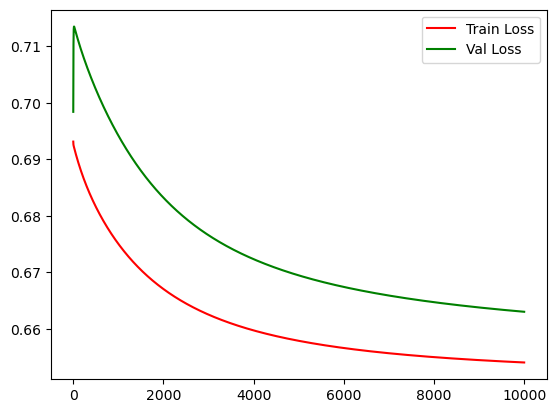

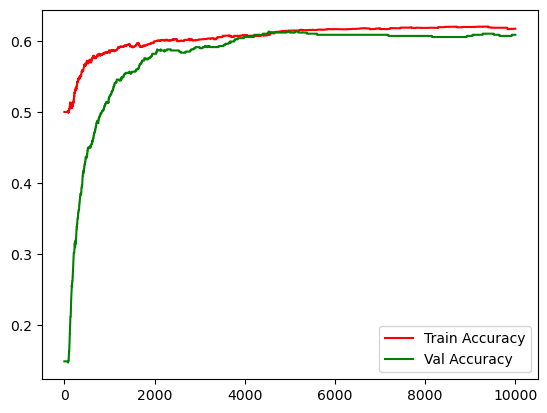

In [79]:
lr = 0.00001
ep = 10000
# batch_size = 10

w, b, tl, ta, vl, va = batch_gradient_descent(x_train_np, y_train_np, x_val_np, y_val_np, lr, ep)
# weights, bias, losses, accuracies , val_losses, val_accuracies
z_test = np.dot(x_test_np, w) + b
y_test_hat = sigmoid(z_test)
y_test_pred_class = [1 if i > 0.5 else 0 for i in y_test_hat]
test_accuracy = accuracy_score(y_test_np, y_test_pred_class)

print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


plt.plot(tl, label='Train Loss', color='red')
plt.plot(vl, label='Val Loss', color='green')
plt.legend()
plt.show()

plt.plot(ta, label='Train Accuracy', color='red')
plt.plot(va, label='Val Accuracy', color='green')
plt.legend()
plt.show()


### checking val accuracy 

In [80]:
z_val = np.dot(x_val_np, w) + b
y_val_hat = sigmoid(z_val)
y_val_pred_class = [1 if i >= 0.5 else 0 for i in y_val_hat]

val_accuracy = accuracy_score(y_val_np, y_val_pred_class)

print(f"Val Accuracy : {val_accuracy * 100:.2f}%")
#Val Accuracy : 60.85%

Val Accuracy : 60.85%


### confusion matrix and other metrics for part c 


In [46]:
confusion_matrix = pd.crosstab(y_val_np, np.array(y_val_pred_class), rownames=['Actual'], colnames=['Predicted'])

print(confusion_matrix)
print(f"Precision: {precision_score(y_val_np, y_val_pred_class)}")
print(f"Recall: {recall_score(y_val_np, y_val_pred_class)}")
print(f"F1 Score: {f1_score(y_val_np, y_val_pred_class)}")

# Predicted    0    1
# Actual             
# 0          324  217
# 1           32   63
# Precision: 0.225
# Recall: 0.6631578947368421
# F1 Score: 0.336


Predicted    0    1
Actual             
0          324  217
1           32   63
Precision: 0.225
Recall: 0.6631578947368421
F1 Score: 0.336


### roc auc and precision recall and f1 score for part c 

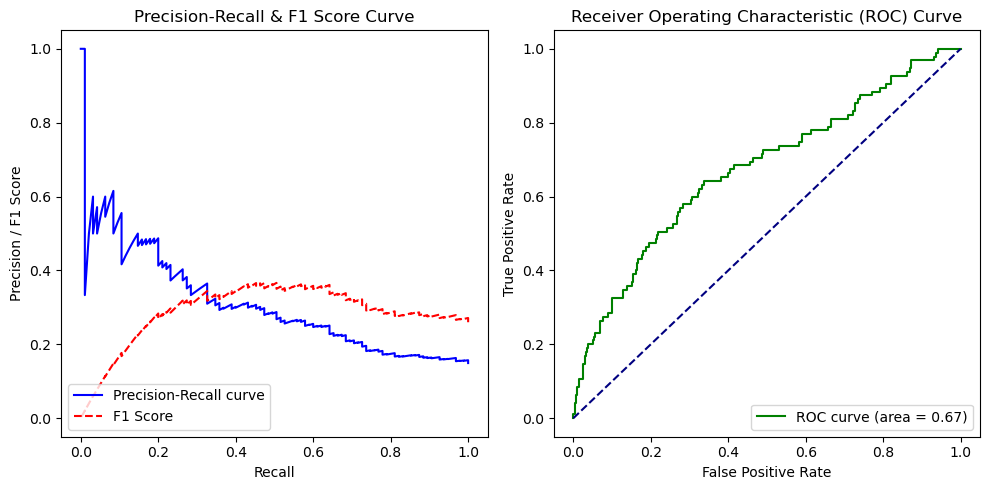

In [41]:

# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_val_np, y_val_hat)
f1_scores = 2 * (precision * recall) / (precision + recall)

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_val_np, y_val_hat)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall and f1 score curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.plot(recall, f1_scores, color='r', linestyle='--', label='F1 Score')
plt.xlabel('Recall')
plt.ylabel('Precision / F1 Score')
plt.title('Precision-Recall & F1 Score Curve')
plt.legend(loc="lower left")

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='g', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


# part b min max scaling 

In [42]:

# Min-max scaling
max_vals = x_train_np.max(axis=0)
min_vals = x_train_np.min(axis=0)
x_train_min_max = (x_train_np - min_vals) / (max_vals - min_vals)
x_test_min_max = (x_test_np - min_vals) / (max_vals - min_vals)
x_val_min_max = (x_val_np - min_vals) / (max_vals - min_vals)

# Train the model with min-max scaling
lr = 0.01
ep = 10000
batch_size = 10

w1, b1, tl1, ta1, vl1, va1 = batch_gradient_descent(x_train_min_max, y_train_np, x_val_min_max, y_val_np, lr, ep)

z_test = np.dot(x_test_min_max, w1) + b1
y_test_hat = sigmoid(z_test)
y_test_pred_cls = [1 if i > 0.5 else 0 for i in y_test_hat]

test_accuracy = accuracy_score(y_test_np, y_test_pred_cls)

print(f"Test Accuracy with Min-Max Scaling: {test_accuracy * 100:.2f}%")





Epoch: 0, Train Loss: 0.6931471805599454, Train Accuracy: 0.5, Val Loss: 0.6933435553302523, Val Accuracy: 0.14937106918238993
Epoch: 100, Train Loss: 0.6876168283441907, Train Accuracy: 0.5224117413724713, Val Loss: 0.7069556737694641, Val Accuracy: 0.1761006289308176
Epoch: 200, Train Loss: 0.6834336374082818, Train Accuracy: 0.5874652915509718, Val Loss: 0.7123572653163427, Val Accuracy: 0.29874213836477986
Epoch: 300, Train Loss: 0.6798423090862308, Train Accuracy: 0.6118603728679095, Val Loss: 0.7133711460164782, Val Accuracy: 0.389937106918239
Epoch: 400, Train Loss: 0.6766106604008421, Train Accuracy: 0.6197937326457755, Val Loss: 0.7121530829569794, Val Accuracy: 0.4386792452830189
Epoch: 500, Train Loss: 0.6736546228766727, Train Accuracy: 0.6277270924236414, Val Loss: 0.709868381104788, Val Accuracy: 0.470125786163522
Epoch: 600, Train Loss: 0.670933520832825, Train Accuracy: 0.6277270924236414, Val Loss: 0.7071311839506457, Val Accuracy: 0.4889937106918239
Epoch: 700, Train 

ValueError: Found input variables with inconsistent numbers of samples: [636, 635]

## testing val accuracy for min max 

In [43]:

z_val = np.dot(x_val_min_max, w1) + b1
y_val_hat = sigmoid(z_val)
y_val_pred_cls = [1 if i > 0.5 else 0 for i in y_val_hat]

val_accuracy = accuracy_score(y_val_np, y_val_pred_cls)

print(f"Val Accuracy with Min-Max Scaling: {val_accuracy * 100:.2f}%")

Val Accuracy with Min-Max Scaling: 66.98%


### precision recall and f1 score curve and roc auc curve 

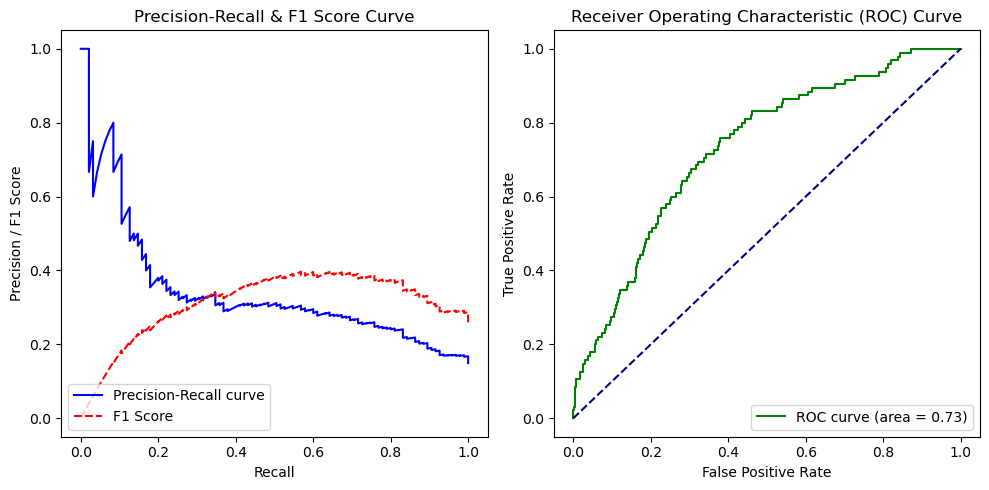

In [44]:


# Precision-Recall curve
precision, recall, thresholds_pr = precision_recall_curve(y_val_np, y_val_hat)
f1_scores = 2 * (precision * recall) / (precision + recall)

# ROC curve
fpr, tpr, thresholds_roc = roc_curve(y_val_np, y_val_hat)
roc_auc = auc(fpr, tpr)

# Plot Precision-Recall curve
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(recall, precision, color='b', label='Precision-Recall curve')
plt.plot(recall, f1_scores, color='r', linestyle='--', label='F1 Score')
plt.xlabel('Recall')
plt.ylabel('Precision / F1 Score')
plt.title('Precision-Recall & F1 Score Curve')
plt.legend(loc="lower left")

# Plot ROC curve
plt.subplot(1, 2, 2)
plt.plot(fpr, tpr, color='g', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()


### confusion matrix and other metrics  for validation set for min max for part c 

In [45]:
confusion_matrix = pd.crosstab(y_val_np, np.array(y_val_pred_cls), rownames=['Actual'], colnames=['Predicted'])

print(confusion_matrix)
print(f"Precision: {precision_score(y_val_np, y_val_pred_cls)}")
print(f"Recall: {recall_score(y_val_np, y_val_pred_cls)}")

print(f"F1 Score: {f1_score(y_val_np, y_val_pred_cls)}")

Predicted    0    1
Actual             
0          360  181
1           29   66
Precision: 0.26720647773279355
Recall: 0.6947368421052632
F1 Score: 0.38596491228070173


## Plots for min max scale vs without scale 

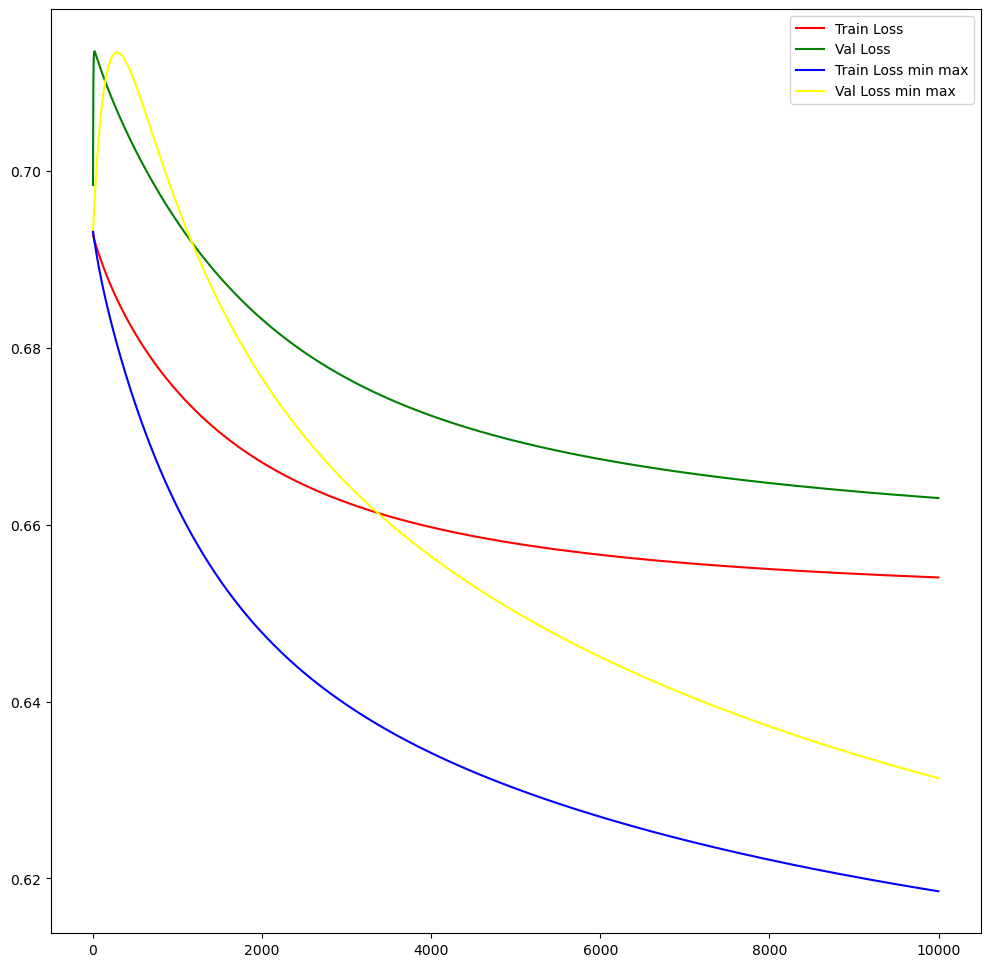

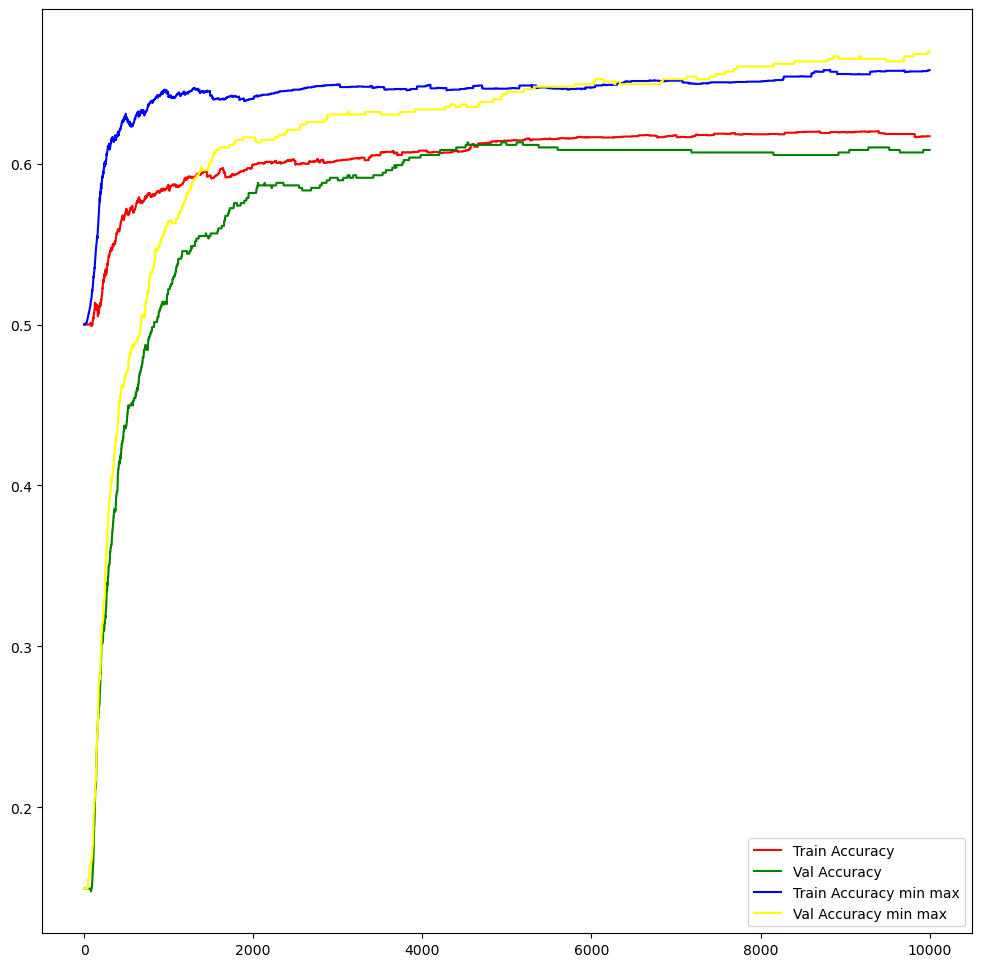

In [12]:
# plot the training and validation losses 
plt.figure(figsize=(12, 12))
plt.plot(tl, label='Train Loss', color='red')
plt.plot(vl, label='Val Loss', color='green')
plt.plot(tl1, label='Train Loss min max', color='blue')
plt.plot(vl1, label='Val Loss min max', color='yellow')

plt.legend()
plt.show()

# Plot training and validation accuracies 
plt.figure(figsize=(12, 12))
plt.plot(ta, label='Train Accuracy', color='red')
plt.plot(va, label='Val Accuracy', color='green')
plt.plot(ta1, label='Train Accuracy min max', color='blue')
plt.plot(va1, label='Val Accuracy min max', color='yellow')
plt.legend()
plt.show()

In [13]:
# CONFUSION MATRIX 
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test_np, y_test_pred_class)
print(cm)

[[351 181]
 [ 34  69]]


# Mini batch for part d on min max transformed data for batch size 10 , 50 , 100 

In [69]:

# Mini-batch gradient descent with batch size of 10
lr = 0.01
ep = 1000
batch_size = 10

w2, b2, tl2, vl2, va2, ta2 = mini_batch_gradient_descent(x_train_min_max, y_train_np, x_val_min_max, y_val_np, lr, ep, batch_size)
# weights, bias, train_losses, val_losses, val_accuracies, train_accuracies
z_test = np.dot(x_test_min_max, w2) + b2
y_test_hat = sigmoid(z_test)
y_test_pred_class1 = [1 if i > 0.5 else 0 for i in y_test_hat]

test_accuracy = accuracy_score(y_test_np, y_test_pred_class1)

print(f"Test Accuracy with Mini-Batch Gradient Descent (Batch Size = 10): {test_accuracy * 100:.2f}%")

# Mini-batch gradient descent with batch size of 50
lr = 0.01
ep = 1000
batch_size = 50

w3, b3, tl3, vl3, va3, ta3 = mini_batch_gradient_descent(x_train_min_max, y_train_np, x_val_min_max, y_val_np, lr, ep, batch_size)

z_test = np.dot(x_test_min_max, w3) + b3
y_test_hat = sigmoid(z_test)
y_test_pred_class2 = [1 if i > 0.5 else 0 for i in y_test_hat]

test_accuracy = accuracy_score(y_test_np, y_test_pred_class2)

print(f"Test Accuracy with Mini-Batch Gradient Descent (Batch Size = 50): {test_accuracy * 100:.2f}%")

# Mini-batch gradient descent with batch size of 100
lr = 0.01
ep = 1000
batch_size = 100

w4, b4, tl4, vl4, va4, ta4 = mini_batch_gradient_descent(x_train_min_max, y_train_np, x_val_min_max, y_val_np, lr, ep, batch_size)

z_test = np.dot(x_test_min_max, w4) + b4
y_test_hat = sigmoid(z_test)

y_test_pred_class3 = [1 if i > 0.5 else 0 for i in y_test_hat]

test_accuracy = accuracy_score(y_test_np, y_test_pred_class3)

print(f"Test Accuracy with Mini-Batch Gradient Descent (Batch Size = 100): {test_accuracy * 100:.2f}%")

#NOW SCHOCATIC GRADIENT DESCENT



Epoch: 0, Train Loss: 0.6735046841963563, Train Accuracy: 0.6295120983736613, Val Loss: 0.7106064843015621, Val Accuracy: 0.46855345911949686
Epoch: 100, Train Loss: 0.603648758743826, Train Accuracy: 0.6628322094406981, Val Loss: 0.6061374634918778, Val Accuracy: 0.6761006289308176
Epoch: 200, Train Loss: 0.6019244058844893, Train Accuracy: 0.6703689012296707, Val Loss: 0.5984401648778148, Val Accuracy: 0.6839622641509434
Epoch: 300, Train Loss: 0.6013755231109417, Train Accuracy: 0.6709639032130107, Val Loss: 0.6022296007843237, Val Accuracy: 0.6871069182389937
Epoch: 400, Train Loss: 0.6011402651536243, Train Accuracy: 0.6691788972629908, Val Loss: 0.608575649031003, Val Accuracy: 0.6808176100628931
Epoch: 500, Train Loss: 0.601109481964814, Train Accuracy: 0.667393891312971, Val Loss: 0.6155605592515153, Val Accuracy: 0.6761006289308176
Epoch: 600, Train Loss: 0.6009822113648039, Train Accuracy: 0.6660055533518445, Val Loss: 0.608917804179493, Val Accuracy: 0.6839622641509434
Epoch

# Stochastic gratient decent on min max transform data for part d 

In [70]:
lr = 0.01
ep = 1000

w5, b5, tl5, ta5, vl5, va5 = stochastic_gradient_descent(x_train_min_max, y_train_np, x_val_min_max, y_val_np, lr, ep)
# return weights, bias, losses, accuracies, val_losses, val_accuracies
z_test = np.dot(x_test_min_max, w5) + b5
y_test_hat = sigmoid(z_test)
y_test_pred_class4 = [1 if i > 0.5 else 0 for i in y_test_hat]

test_accuracy = accuracy_score(y_test_np, y_test_pred_class4)

print(f"Test Accuracy with Stochastic Gradient Descent: {test_accuracy * 100:.2f}%")




Epoch: 0, Train Loss: 0.6306204022781052, Train Accuracy: 0.6543038476794922, Val Loss: 0.6709289193358089, Val Accuracy: 0.6163522012578616
Epoch: 100, Train Loss: 0.6012116165028686, Train Accuracy: 0.6717572391907973, Val Loss: 0.6227075426168006, Val Accuracy: 0.6698113207547169
Epoch: 200, Train Loss: 0.6012014332630217, Train Accuracy: 0.671360571201904, Val Loss: 0.6229409110842337, Val Accuracy: 0.6713836477987422
Epoch: 300, Train Loss: 0.6012012471317849, Train Accuracy: 0.6701705672352242, Val Loss: 0.6229565218818156, Val Accuracy: 0.6713836477987422
Epoch: 400, Train Loss: 0.6012012371573862, Train Accuracy: 0.6701705672352242, Val Loss: 0.6229575826536339, Val Accuracy: 0.6713836477987422
Epoch: 500, Train Loss: 0.601201236490271, Train Accuracy: 0.6701705672352242, Val Loss: 0.6229576557788326, Val Accuracy: 0.6713836477987422
Epoch: 600, Train Loss: 0.6012012364443781, Train Accuracy: 0.6701705672352242, Val Loss: 0.622957660846617, Val Accuracy: 0.6713836477987422
Epoc

## Combined plot 

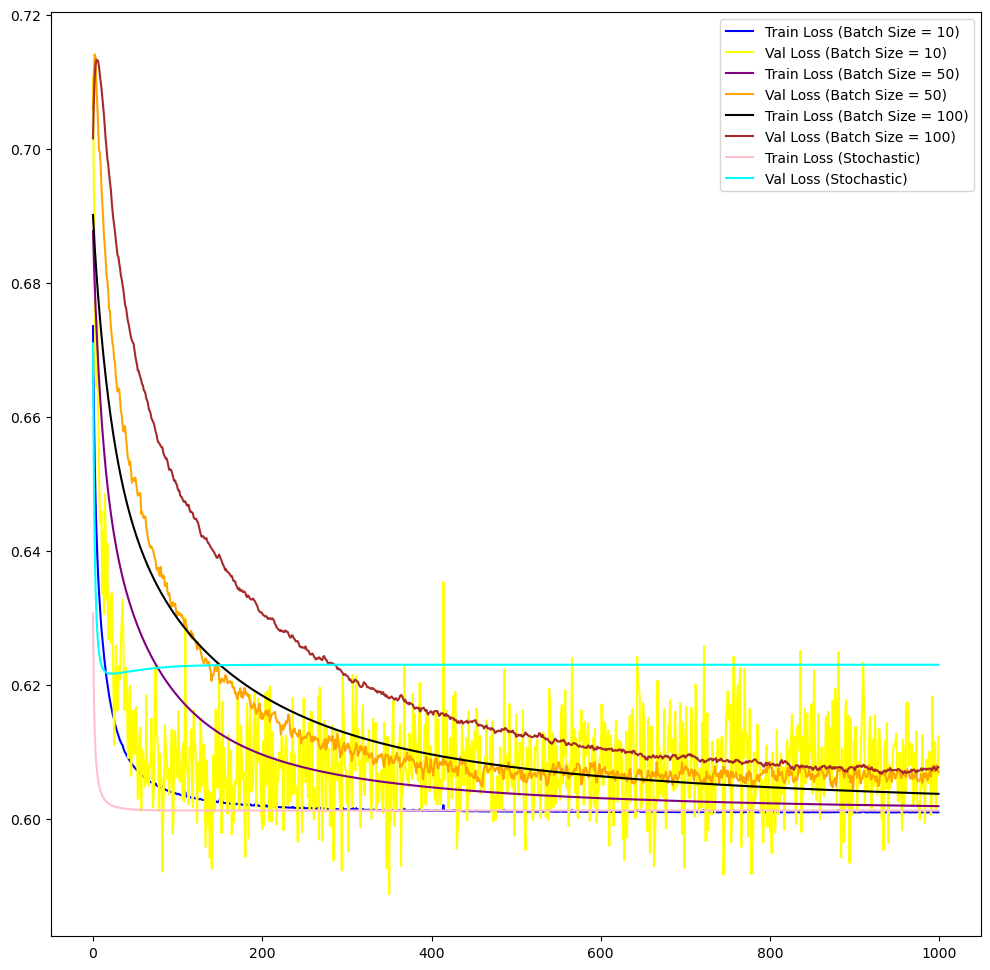

In [71]:
plt.figure(figsize=(12, 12))
# plt.plot(tl, label='Train Loss', color='red')
# plt.plot(vl, label='Val Loss', color='green')
plt.plot(tl2, label='Train Loss (Batch Size = 10)', color='blue')
plt.plot(vl2, label='Val Loss (Batch Size = 10)', color='yellow')
plt.plot(tl3, label='Train Loss (Batch Size = 50)', color='purple')
plt.plot(vl3, label='Val Loss (Batch Size = 50)', color='orange')
plt.plot(tl4, label='Train Loss (Batch Size = 100)', color='black')
plt.plot(vl4, label='Val Loss (Batch Size = 100)', color='brown')
plt.plot(tl5, label='Train Loss (Stochastic)', color='pink')
plt.plot(vl5, label='Val Loss (Stochastic)', color='cyan')
plt.legend()
plt.show()


## combined train loss curve 

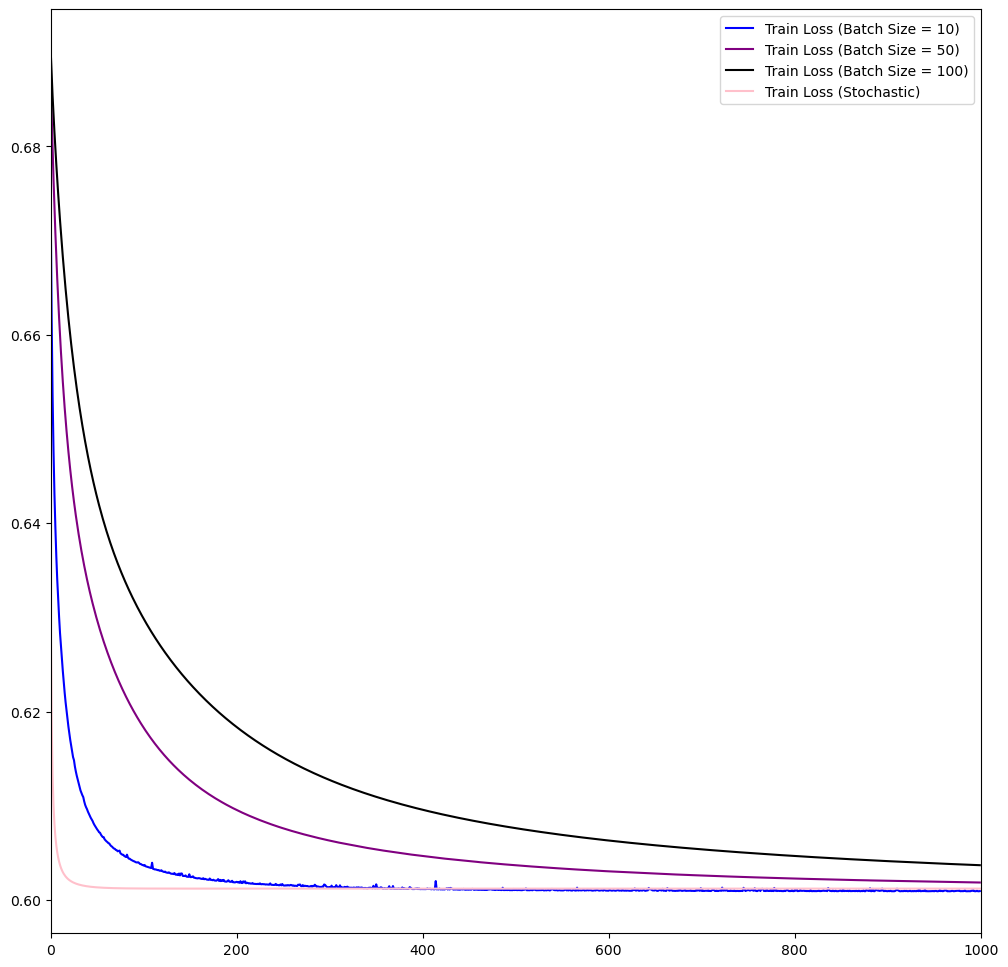

In [81]:
# plt.figure(figsize=(12, 12))
# # plt.plot(tl, label='Train Loss', color='red')
# # plt.plot(vl, label='Val Loss', color='green')
# plt.plot(tl2, label='Train Loss (Batch Size = 10)', color='blue')
# plt.plot(vl2, label='Val Loss (Batch Size = 10)', color='yellow')
# plt.plot(tl3, label='Train Loss (Batch Size = 50)', color='purple')
# plt.plot(vl3, label='Val Loss (Batch Size = 50)', color='orange')
# plt.plot(tl4, label='Train Loss (Batch Size = 100)', color='black')
# plt.plot(vl4, label='Val Loss (Batch Size = 100)', color='brown')
# plt.plot(tl5, label='Train Loss (Stochastic)', color='pink')
# plt.plot(vl5, label='Val Loss (Stochastic)', color='cyan')
# plt.legend()
# plt.show()

plt.figure(figsize=(12, 12))
# plt.plot(tl1, label='Train Loss(batch gradient )', color='red')
# plt.plot(vl, label='Val Loss', color='green')
plt.plot(tl2, label='Train Loss (Batch Size = 10)', color='blue')
# plt.plot(vl2, label='Val Loss (Batch Size = 10)', color='yellow')
plt.plot(tl3, label='Train Loss (Batch Size = 50)', color='purple')
# plt.plot(vl3, label='Val Loss (Batch Size = 50)', color='orange')
plt.plot(tl4, label='Train Loss (Batch Size = 100)', color='black')
# plt.plot(vl4, label='Val Loss (Batch Size = 100)', color='brown')
plt.plot(tl5, label='Train Loss (Stochastic)', color='pink')
# plt.plot(vl5, label='Val Loss (Stochastic)', color='cyan')
# set range from 0 to 1000 for x
plt.xlim(0, 1000)

plt.legend()
plt.show()

## all loss accuracy curve seperate 


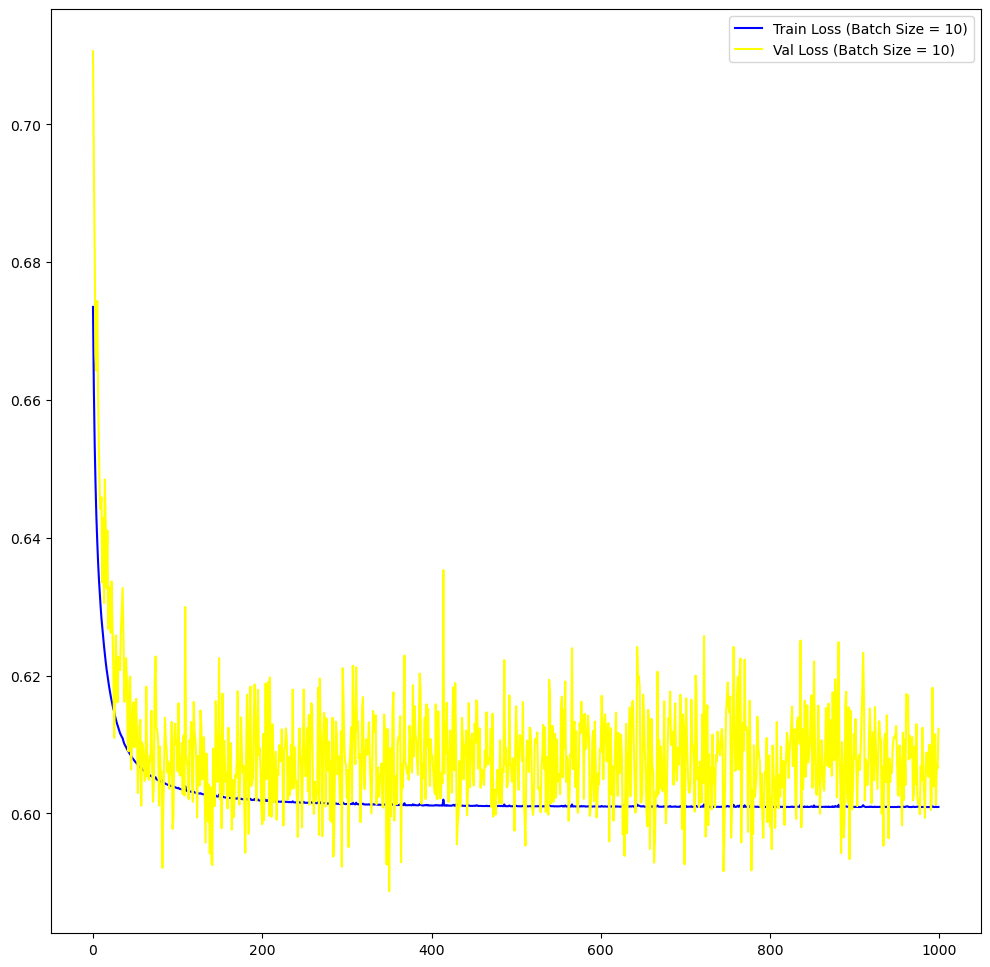

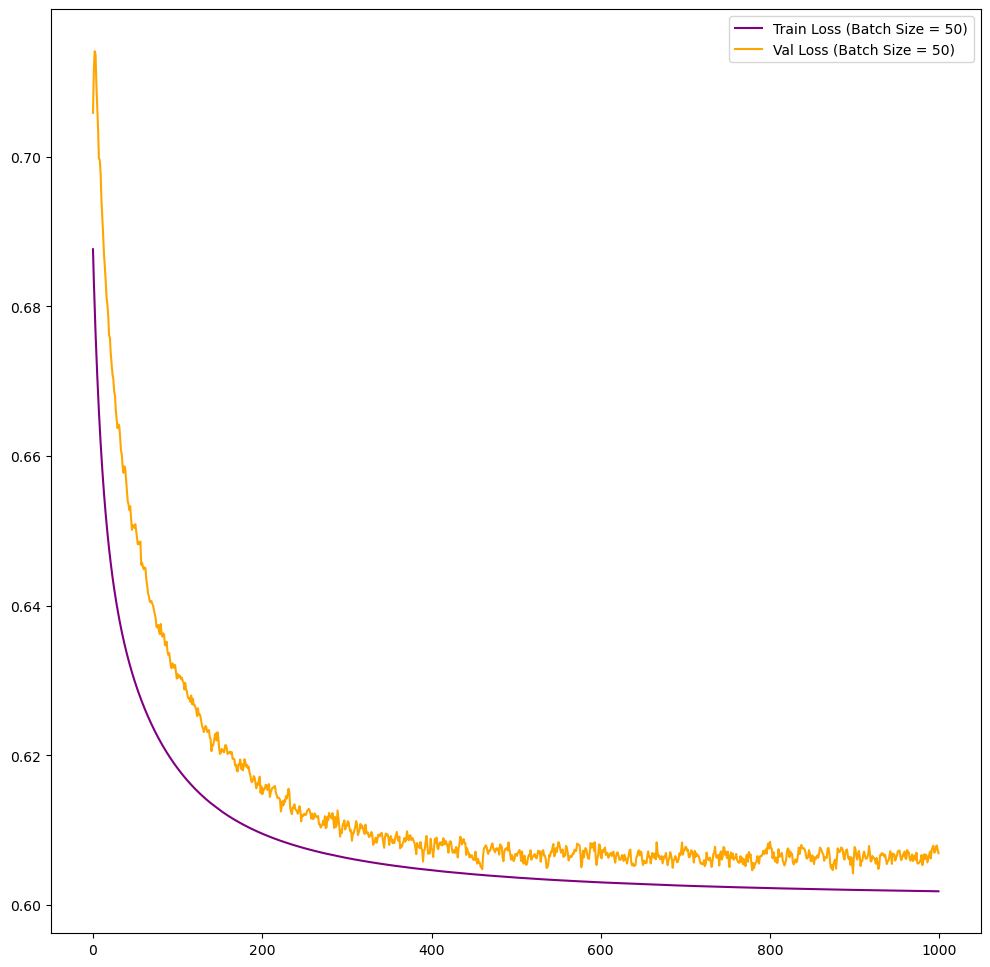

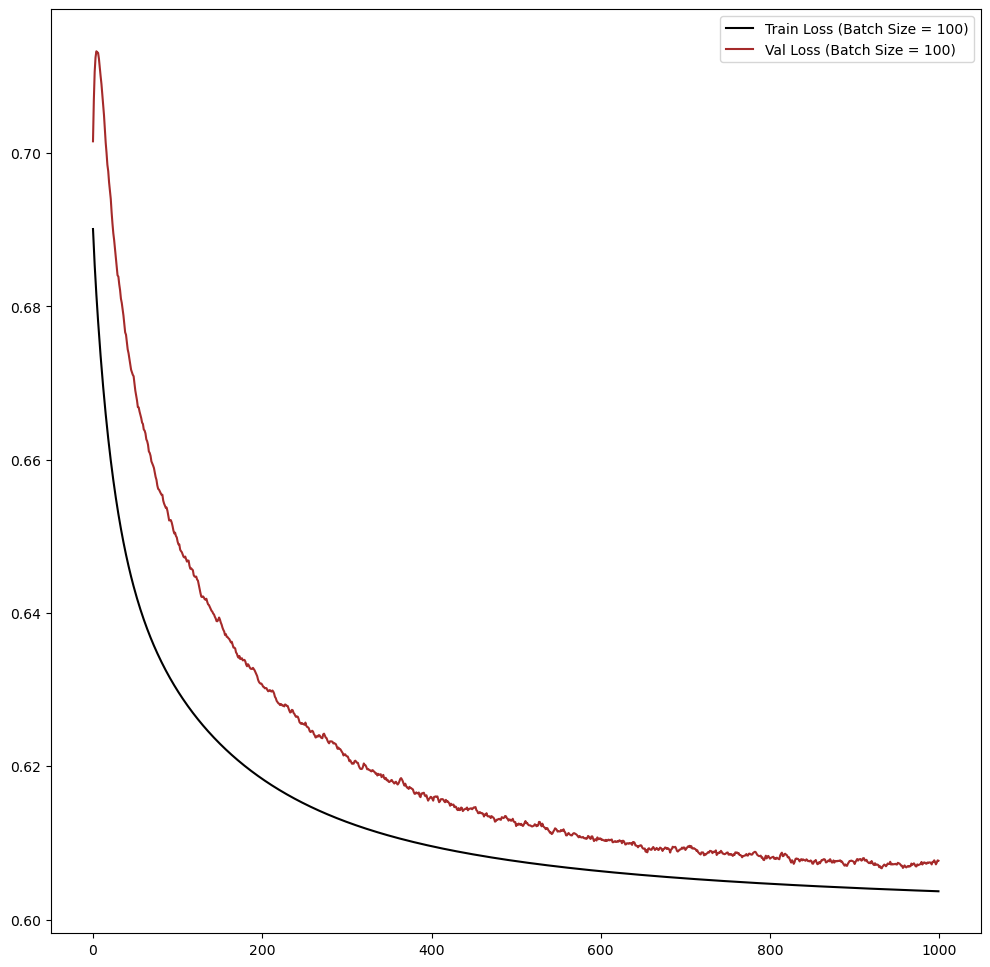

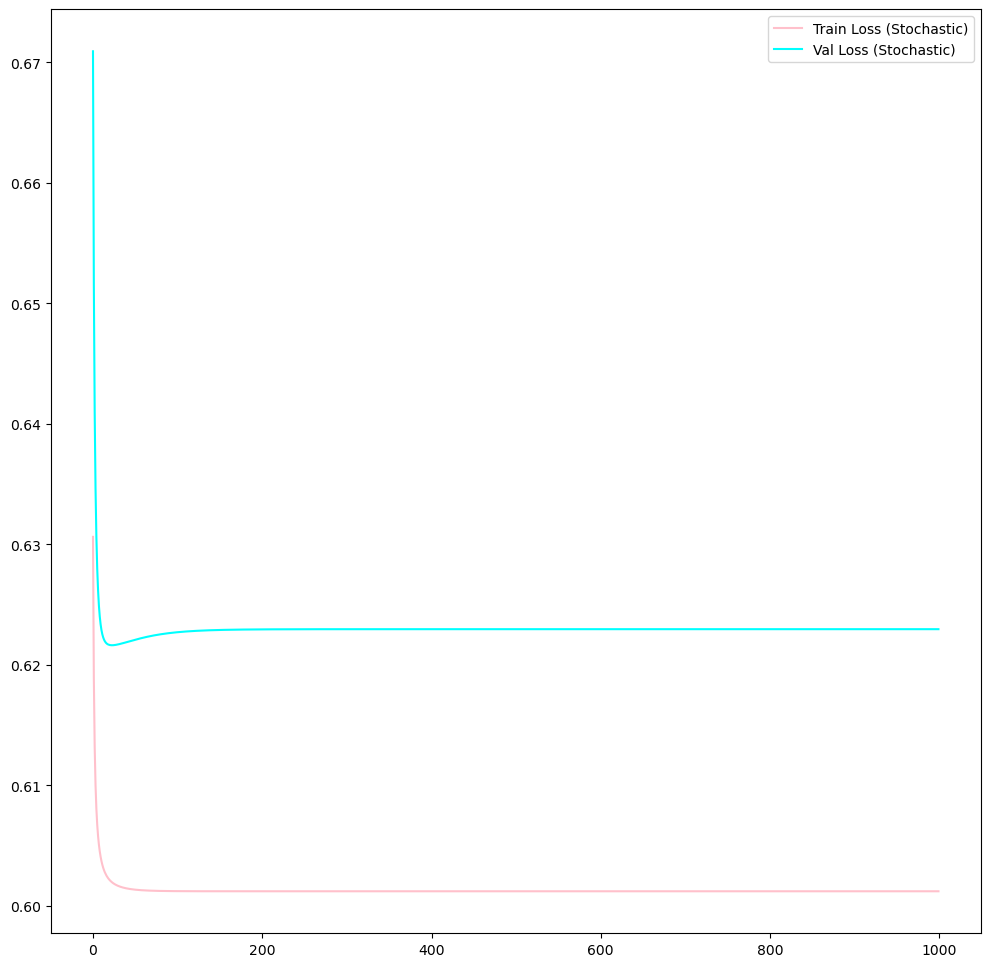

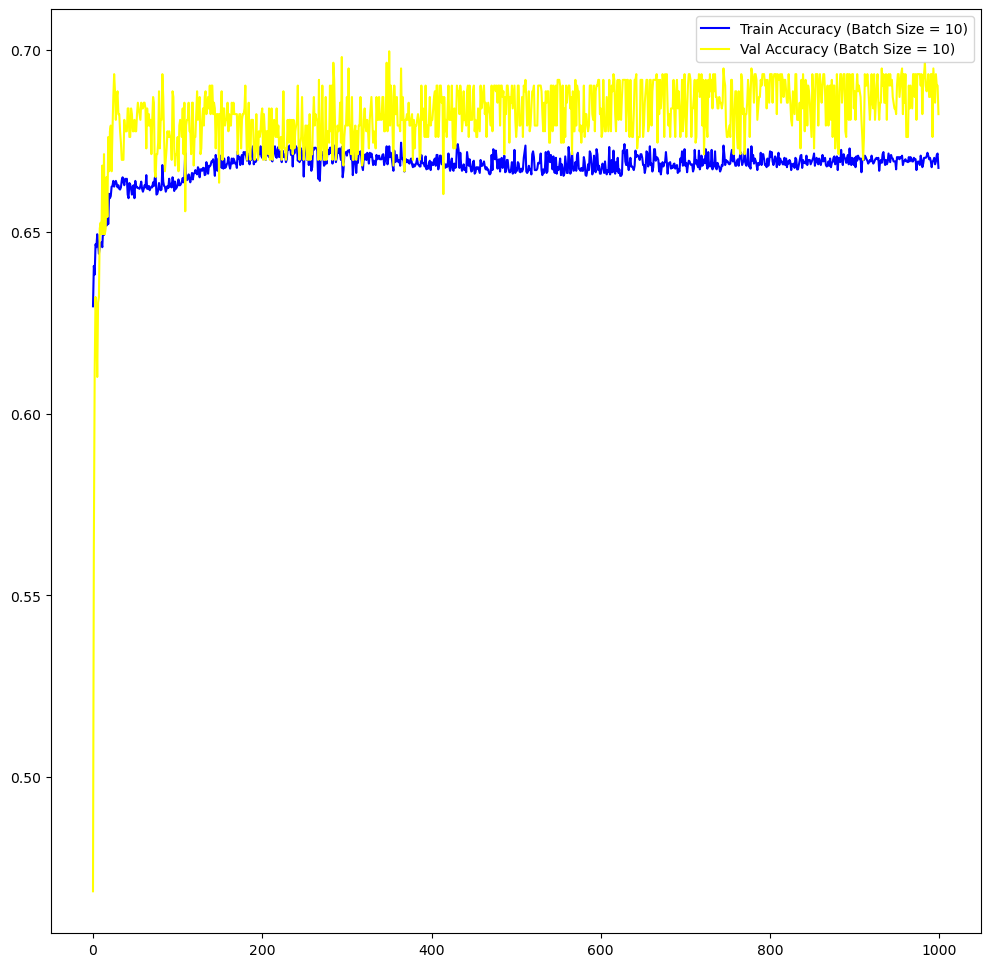

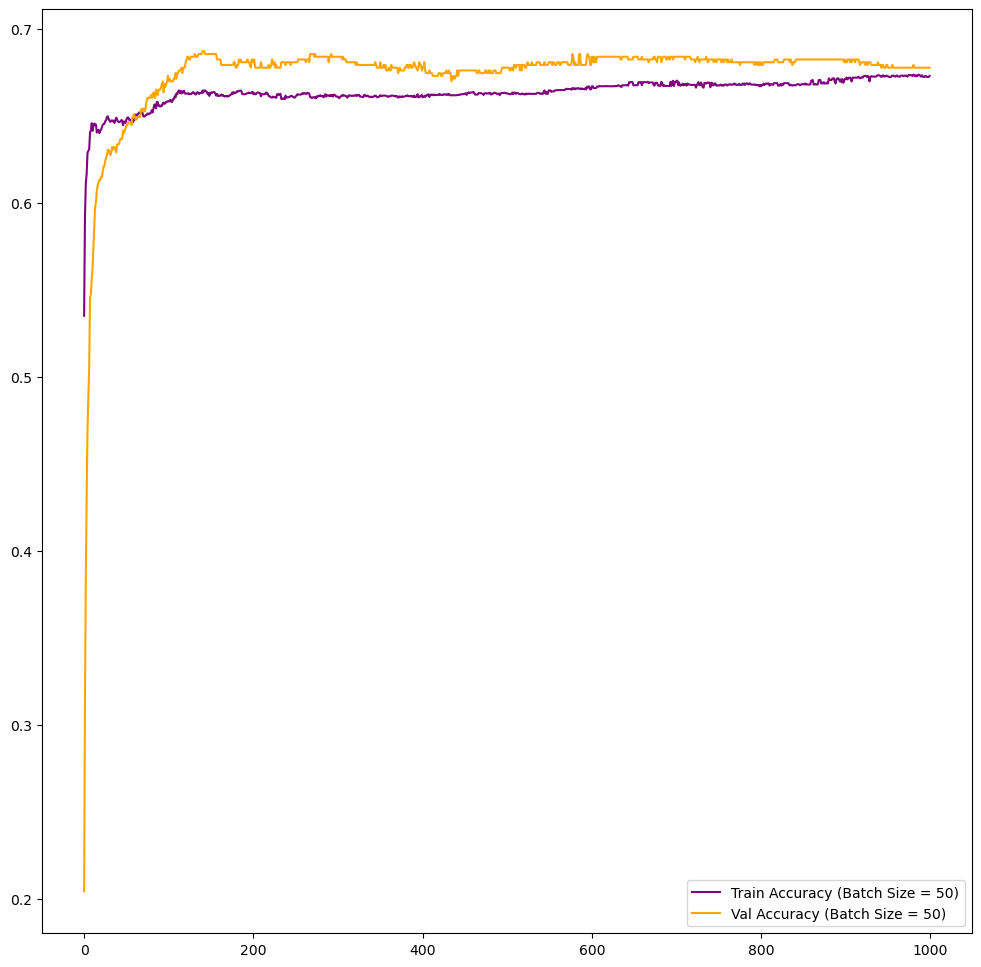

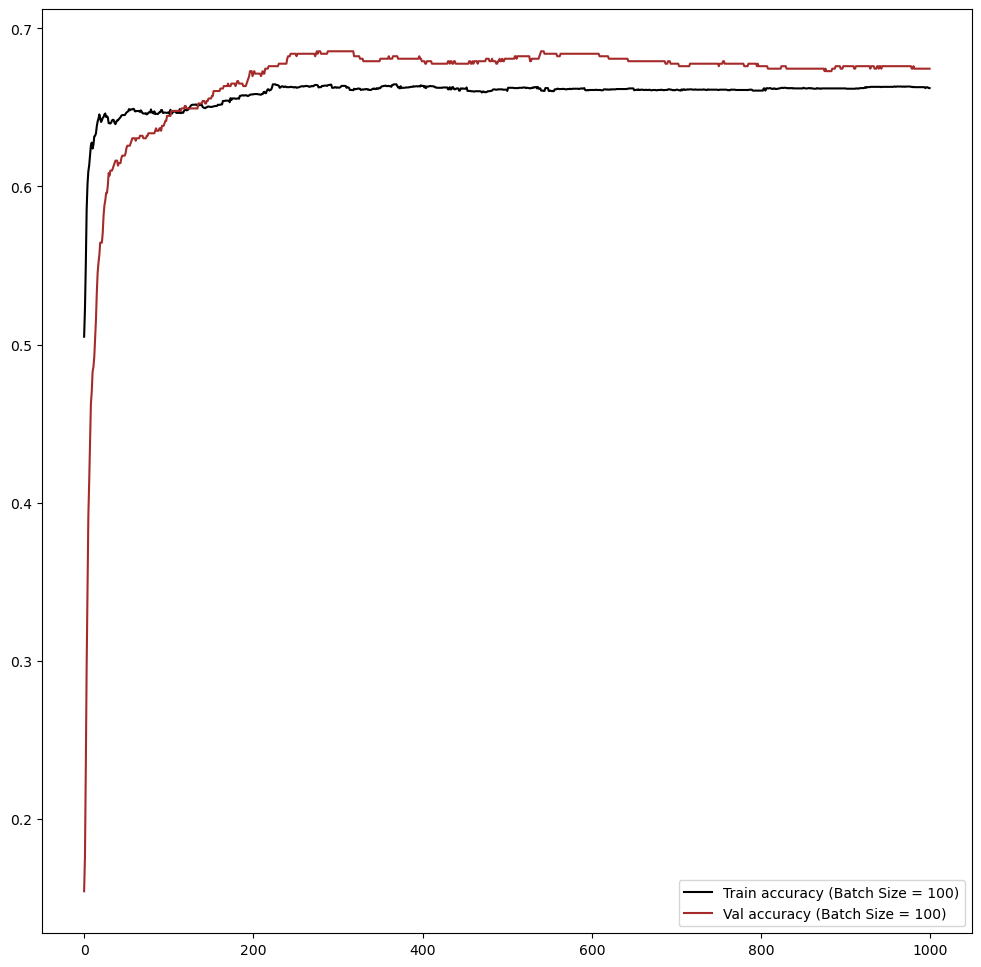

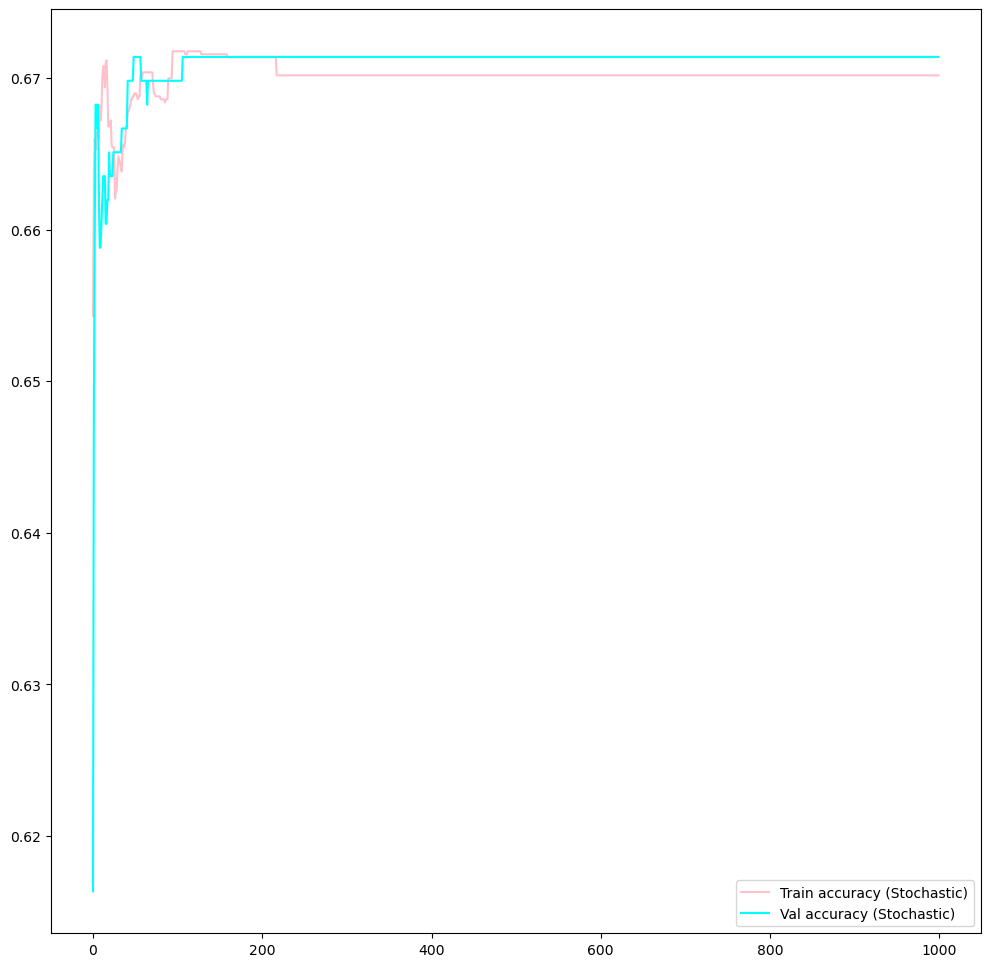

In [73]:
# plot the training and validation losses for batch size 10 

plt.figure(figsize=(12, 12))
plt.plot(tl2, label='Train Loss (Batch Size = 10)', color='blue')
plt.plot(vl2, label='Val Loss (Batch Size = 10)', color='yellow')
plt.legend()
plt.show()

# plot the training and validation losses for batch size 50

plt.figure(figsize=(12, 12))
plt.plot(tl3, label='Train Loss (Batch Size = 50)', color='purple')
plt.plot(vl3, label='Val Loss (Batch Size = 50)', color='orange')
plt.legend()
plt.show()

# plot the training and validation losses for batch size 100
plt.figure(figsize=(12, 12))
plt.plot(tl4, label='Train Loss (Batch Size = 100)', color='black')
plt.plot(vl4, label='Val Loss (Batch Size = 100)', color='brown')
plt.legend()
plt.show()

# plot the training and validation losses for stochastic gradient descent
plt.figure(figsize=(12, 12))
plt.plot(tl5, label='Train Loss (Stochastic)', color='pink')
plt.plot(vl5, label='Val Loss (Stochastic)', color='cyan')
plt.legend()
plt.show()

# plot the training and validation accuracies for batch size 10
plt.figure(figsize=(12, 12))
plt.plot(ta2, label='Train Accuracy (Batch Size = 10)', color='blue')
plt.plot(va2, label='Val Accuracy (Batch Size = 10)', color='yellow')
plt.legend()
plt.show()

# plot the training and validation accuracies for batch size 50
plt.figure(figsize=(12, 12))
plt.plot(ta3, label='Train Accuracy (Batch Size = 50)', color='purple')
plt.plot(va3, label='Val Accuracy (Batch Size = 50)', color='orange')
plt.legend()
plt.show()

# plot the training and validation accuracies for batch size 100
plt.figure(figsize=(12, 12))
plt.plot(ta4, label='Train accuracy (Batch Size = 100)', color='black')
plt.plot(va4, label='Val accuracy (Batch Size = 100)', color='brown')
plt.legend()
plt.show()

# plot the training and validation accuracies for stochastic gradient descent
plt.figure(figsize=(12, 12))
plt.plot(ta5, label='Train accuracy (Stochastic)', color='pink')
plt.plot(va5, label='Val accuracy (Stochastic)', color='cyan')
plt.legend()
plt.show()

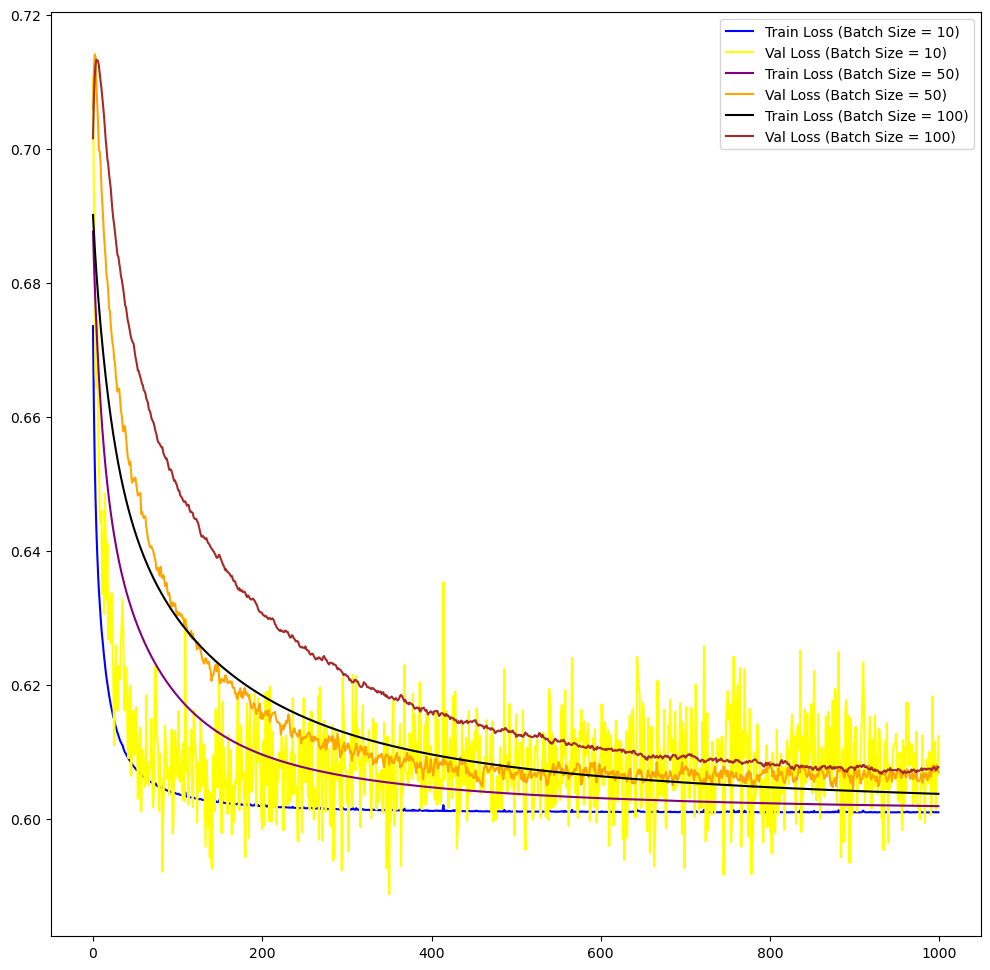

In [74]:
plt.figure(figsize=(12, 12))
# plt.plot(tl, label='Train Loss', color='red')
# plt.plot(vl, label='Val Loss', color='green')
plt.plot(tl2, label='Train Loss (Batch Size = 10)', color='blue')
plt.plot(vl2, label='Val Loss (Batch Size = 10)', color='yellow')
plt.plot(tl3, label='Train Loss (Batch Size = 50)', color='purple')
plt.plot(vl3, label='Val Loss (Batch Size = 50)', color='orange')
plt.plot(tl4, label='Train Loss (Batch Size = 100)', color='black')
plt.plot(vl4, label='Val Loss (Batch Size = 100)', color='brown')
# plt.plot(tl5, label='Train Loss (Stochastic)', color='pink')
# plt.plot(vl5, label='Val Loss (Stochastic)', color='cyan')
plt.legend()
plt.show()


# confusion_matrix


## confusion matrix for all 4

[[317 215]
 [ 37  66]]


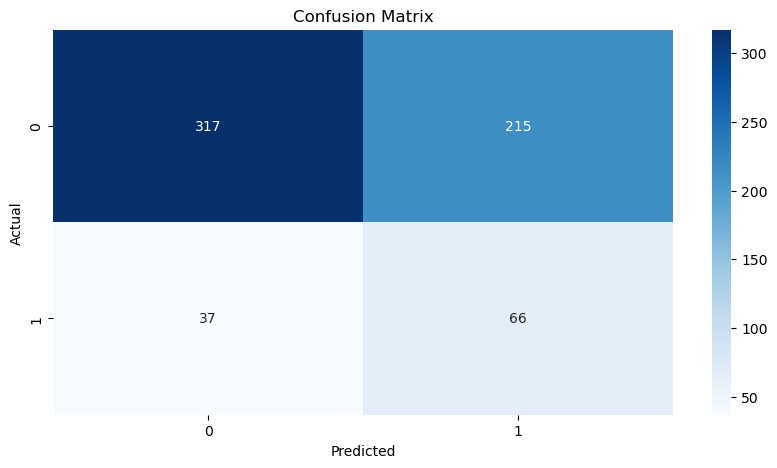

[[356 176]
 [ 33  70]]


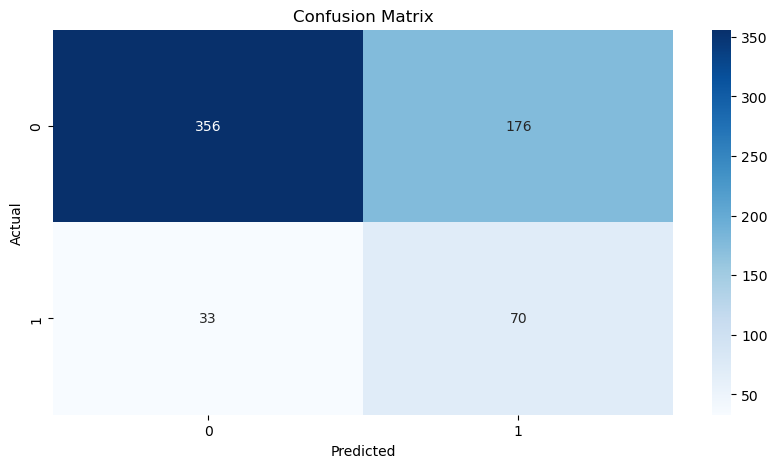

[[357 175]
 [ 32  71]]


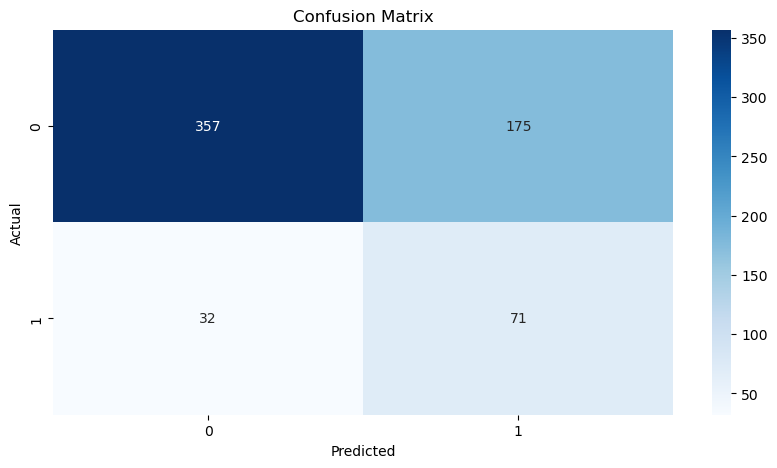

[[357 175]
 [ 36  67]]


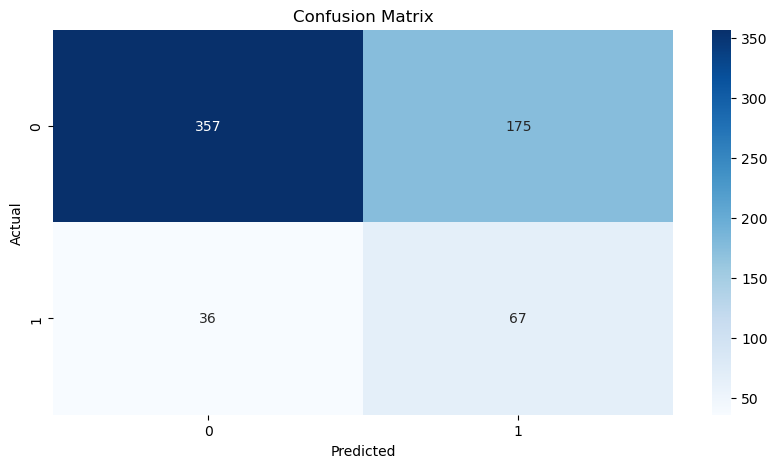

[[345 187]
 [ 32  71]]


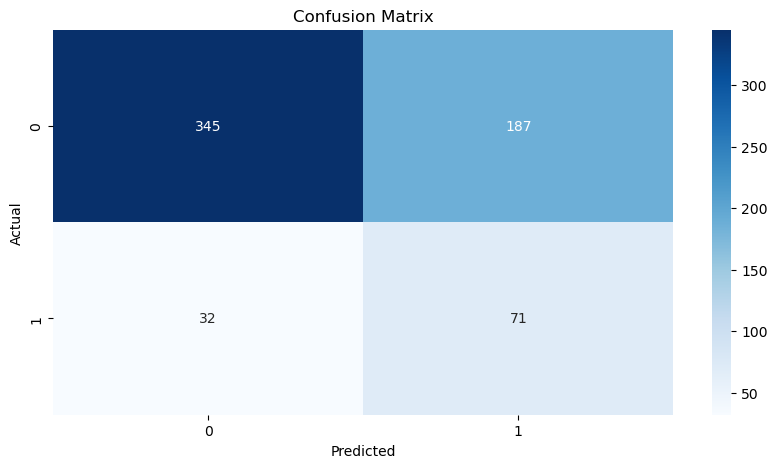

In [67]:
# confusion_matrix
cm = confusion_matrix(y_test_np, y_test_pred_class)
print(cm)

plt.figure(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
# confusion_matrix for all the models
other = [y_test_pred_class1, y_test_pred_class2, y_test_pred_class3, y_test_pred_class4]

for i in other:
    cm = confusion_matrix(y_test_np, i)
    print(cm)

    plt.figure(figsize=(10, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()


# part e k fold cross validation 


#### For this I am splitting into 5 fold and for each of 5 i have done upsampling for train data 

In [109]:
# k fold cross validation
x = data_copy.iloc[:, :-1].values
y = data_copy.iloc[:, -1].values


x = (x - x.max(axis=0)) / (x.max(axis=0) - x.min(axis=0))

k_fold_cross_validation(x, y, k=5)
#results
# [0.69185360094451, 0.6635182998819362, 0.6587957497048406, 0.6469893742621016, 0.7012987012987013]
# Average Accuracy: 0.67, Standard Deviation: 0.02
# [0.27759197324414714, 0.25, 0.27953890489913547, 0.26822157434402333, 0.2596491228070175]
# Average Precision: 0.27, Standard Deviation: 0.01
# [0.6484375, 0.6585365853658537, 0.7132352941176471, 0.6571428571428571, 0.6379310344827587]
# Average Recall: 0.66, Standard Deviation: 0.03
# [0.38875878220140514, 0.3624161073825503, 0.40165631469979296, 0.38095238095238093, 0.3690773067331671]
# Average F1 Score: 0.38, Standard Deviation: 0.01


Before Upsampling:
0    2875
1     516
dtype: int64
After Upsampling:
0    2875
1    2875
dtype: int64
Epoch: 0, Train Loss: 0.687189221989991, Train Accuracy: 0.5608695652173913, Val Loss: 0.6704616785797071, Val Accuracy: 0.8122786304604487
Epoch: 100, Train Loss: 0.6191986891532085, Train Accuracy: 0.672695652173913, Val Loss: 0.6323164604293103, Val Accuracy: 0.6469893742621016
Epoch: 200, Train Loss: 0.6133506719813763, Train Accuracy: 0.6707826086956522, Val Loss: 0.6104466328013641, Val Accuracy: 0.6635182998819362
Epoch: 300, Train Loss: 0.6113935964149422, Train Accuracy: 0.6700869565217391, Val Loss: 0.6237356960777395, Val Accuracy: 0.6576151121605667
Epoch: 400, Train Loss: 0.6101277226003367, Train Accuracy: 0.6711304347826087, Val Loss: 0.6091108580963771, Val Accuracy: 0.6646989374262101
Epoch: 500, Train Loss: 0.6092004342539098, Train Accuracy: 0.6707826086956522, Val Loss: 0.6138143281231132, Val Accuracy: 0.6694214876033058
Epoch: 600, Train Loss: 0.6084533352309882,

# implementing early stopping in mini batch gradient decent for part f

In [113]:
def mini_batch_gradient_descent_early_stopping(X_train, y_train, X_val, y_val, learning_rate=0.01,Epoch=1000, batch_size=10):
    m, n = X_train.shape
    weights = np.zeros(n)
    bias = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []

    best_val_loss = np.inf
    patience = 100
    tolerance = 1e-7
    
    for i in range(Epoch):
        indices = np.random.permutation(m)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            z = np.dot(X_batch, weights) + bias
            y_hat = sigmoid_clip(z)
            
            dw = (1/batch_size) * np.dot(X_batch.T, (y_hat - y_batch))
            db = (1/batch_size) * np.sum(y_hat - y_batch)
            
            weights -= learning_rate * dw
            bias -= learning_rate * db

        z_train = np.dot(X_train, weights) + bias
        y_train_hat = sigmoid_clip(z_train)
        train_loss = cross_entropy_clip(y_train, y_train_hat)
        
        
        z_val = np.dot(X_val, weights) + bias
        y_val_hat = sigmoid_clip(z_val)
        val_loss = cross_entropy_clip(y_val, y_val_hat)
        
        
        y_val_pred_class = [1 if i > 0.5 else 0 for i in y_val_hat]
        val_accuracy = accuracy_score(y_val, y_val_pred_class)
        

        y_train_pred_class = [1 if i > 0.5 else 0 for i in y_train_hat]
        train_accuracy = accuracy_score(y_train, y_train_pred_class)
        
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)
        if val_loss < best_val_loss - tolerance:  # Improvement is significant
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
        
        # Check for early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i+ 1}. Best validation loss: {best_val_loss}")
            break

        if i % 100 == 0:
            
            print(f"Epoch: {i}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
            
    return weights, bias, train_losses, val_losses, val_accuracies, train_accuracies

In [114]:

lr = 0.01
ep = 1000
batch_size = 50

w, b, tl, ta, vl, va = mini_batch_gradient_descent_early_stopping(x_train_min_max, y_train_np, x_val_min_max, y_val_np, lr, ep, batch_size)

z_test = np.dot(x_test_min_max, w) + b
y_test_hat = sigmoid(z_test)
y_test_pred_class = [1 if i > 0.5 else 0 for i in y_test_hat]

test_accuracy = accuracy_score(y_test_np, y_test_pred_class)

print(f"Test Accuracy with Early Stopping: {test_accuracy * 100:.2f}%")

Epoch: 0, Train Loss: 0.6874758209780356, Train Accuracy: 0.5083300277667592, Val Loss: 0.7092117015989077, Val Accuracy: 0.15566037735849056
Epoch: 100, Train Loss: 0.6182713328207983, Train Accuracy: 0.6584688615628719, Val Loss: 0.6300941052114722, Val Accuracy: 0.6729559748427673
Epoch: 200, Train Loss: 0.6095451569851066, Train Accuracy: 0.6632288774295915, Val Loss: 0.6163285509951733, Val Accuracy: 0.6776729559748428
Epoch: 300, Train Loss: 0.6062954454923343, Train Accuracy: 0.6610472034906782, Val Loss: 0.6105075613434554, Val Accuracy: 0.6839622641509434
Epoch: 400, Train Loss: 0.6046595360973308, Train Accuracy: 0.6620388734629116, Val Loss: 0.6086516000825193, Val Accuracy: 0.6761006289308176
Epoch: 500, Train Loss: 0.6036796357845985, Train Accuracy: 0.6626338754462515, Val Loss: 0.6070868424470737, Val Accuracy: 0.6761006289308176
Epoch: 600, Train Loss: 0.6030373897135065, Train Accuracy: 0.6664022213407378, Val Loss: 0.6069008295731013, Val Accuracy: 0.6839622641509434


In [100]:
def mini_batch_gradient_descent_early_stopping_regularised(X_train, y_train, X_val, y_val, learning_rate=0.01, Epoch=1000, batch_size=10, reg=1,reg_factor=0.01):
    m, n = X_train.shape
    weights = np.zeros(n)
    bias = 0
    train_losses = []
    val_losses = []
    val_accuracies = []
    train_accuracies = []
    best_val_loss = np.inf
    patience = 1000
    tolerance = 1e-7
    patience_counter = 0
    
    for i in range(Epoch):
        indices = np.random.permutation(m)
        X_train_shuffled = X_train[indices]
        y_train_shuffled = y_train[indices]
        
        for start in range(0, m, batch_size):
            end = start + batch_size
            X_batch = X_train_shuffled[start:end]
            y_batch = y_train_shuffled[start:end]
            
            z = np.dot(X_batch, weights) + bias
            y_hat = sigmoid_clip(z)
            
            # Calculate gradients
            dw = (1/batch_size) * np.dot(X_batch.T, (y_hat - y_batch))
            db = (1/batch_size) * np.sum(y_hat - y_batch)
            
            # L2 Regularization (Ridge)
            if reg==1:
                dw += (reg_factor / batch_size) * weights

            # L1 Regularization (Lasso)
            if reg==2:
                dw += (reg_factor / batch_size) * np.sign(weights)
            
            # Update weights and bias
            weights -= learning_rate * dw
            bias -= learning_rate * db

        # Compute training and validation loss
        z_train = np.dot(X_train, weights) + bias
        y_train_hat = sigmoid_clip(z_train)
        train_loss = cross_entropy_clip(y_train, y_train_hat)
        
        z_val = np.dot(X_val, weights) + bias
        y_val_hat = sigmoid_clip(z_val)
        val_loss = cross_entropy_clip(y_val, y_val_hat)
        y_val_pred_class = [1 if i > 0.5 else 0 for i in y_val_hat]
        val_accuracy = accuracy_score(y_val, y_val_pred_class)

        y_train_pred_class = [1 if i > 0.5 else 0 for i in y_train_hat]
        train_accuracy = accuracy_score(y_train, y_train_pred_class)

        # Store loss and accuracy
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
        train_accuracies.append(train_accuracy)

        # Early stopping based on validation loss
        if val_loss < best_val_loss - tolerance:  # Improvement is significant
            best_val_loss = val_loss
            patience_counter = 0  # Reset patience counter
        else:
            patience_counter += 1
        
        # Check if early stopping should be triggered
        if patience_counter >= patience:
            print(f"Early stopping at epoch {i + 1}. Best validation loss: {best_val_loss}")
            break

        if i % 100 == 0:
            print(f"Epoch: {i}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}")
    
    return weights, bias, train_losses, val_losses, val_accuracies, train_accuracies


Epoch: 0, Train Loss: 0.6875663070756688, Train Accuracy: 0.5204284014280047, Val Loss: 0.7072719082556641, Val Accuracy: 0.16981132075471697
Epoch: 100, Train Loss: 0.6183989849439934, Train Accuracy: 0.6578738595795319, Val Loss: 0.6316592751098076, Val Accuracy: 0.6682389937106918
Epoch: 200, Train Loss: 0.6097248057183741, Train Accuracy: 0.6624355414518048, Val Loss: 0.6163396002124228, Val Accuracy: 0.6792452830188679
Epoch: 300, Train Loss: 0.6064865244163645, Train Accuracy: 0.6614438714795716, Val Loss: 0.6106243399358371, Val Accuracy: 0.6839622641509434
Epoch: 400, Train Loss: 0.6048602771577438, Train Accuracy: 0.6616422054740182, Val Loss: 0.6095228188741049, Val Accuracy: 0.6729559748427673
Epoch: 500, Train Loss: 0.6038916173831989, Train Accuracy: 0.6622372074573581, Val Loss: 0.6081338162284605, Val Accuracy: 0.6761006289308176
Epoch: 600, Train Loss: 0.6032605839606426, Train Accuracy: 0.6654105513685046, Val Loss: 0.6067439274069005, Val Accuracy: 0.6792452830188679


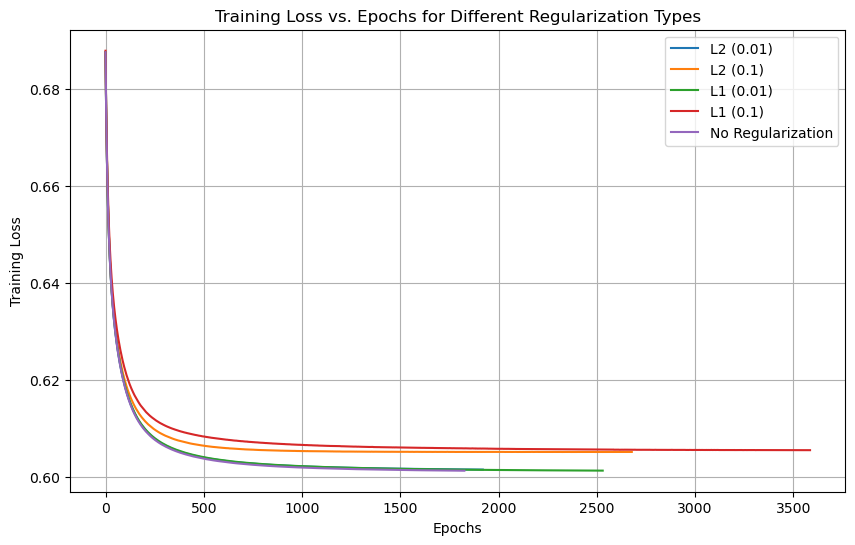

In [118]:
regs = [(1, 0.01), (1, 0.1), (2, 0.01), (2, 0.1)] 
labels = ["L2 (0.01)", "L2 (0.1)", "L1 (0.01)", "L1 (0.1)", "No Regularization"]
train_loss_results = []
val_loss_results = []
val_accuracies_result= []
# Loop through regularization parameters and store the results
for reg, reg_factor in regs:
    weights, bias, train_losses, val_losses, val_accuracies, train_accuracies = mini_batch_gradient_descent_early_stopping_regularised(
        x_train_min_max, y_train_np, x_val_min_max, y_val_np, learning_rate=0.01, Epoch=10000, batch_size=50, reg=reg, reg_factor=reg_factor)
    train_loss_results.append(train_losses)
    val_loss_results.append(val_losses)
    val_accuracies_result.append(val_accuracies)
weights, bias, train_losses, val_losses, val_accuracies, train_accuracies = mini_batch_gradient_descent_early_stopping_regularised(
        x_train_min_max, y_train_np, x_val_min_max, y_val_np, learning_rate=0.01, Epoch=10000, batch_size=50 , reg=0, reg_factor=0.01)
train_loss_results.append(train_losses)
val_loss_results.append(val_losses)
val_accuracies_result.append(val_accuracies)
# Plotting all the training loss curves
plt.figure(figsize=(10, 6))
for i, losses in enumerate(train_loss_results):
    plt.plot(losses, label=labels[i])

plt.title('Training Loss vs. Epochs for Different Regularization Types')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

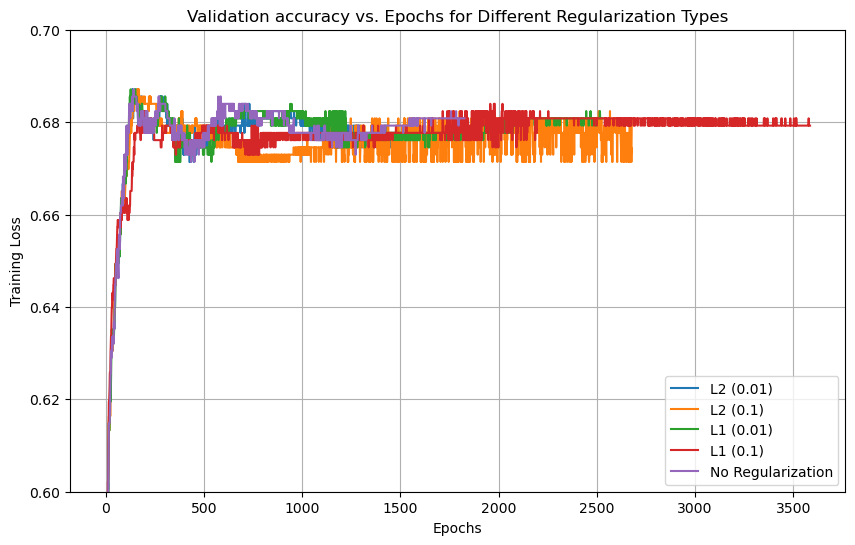

In [120]:
plt.figure(figsize=(10, 6))
for i, losses in enumerate(val_accuracies_result):
    plt.plot(losses, label=labels[i])
plt.ylim(0.6,0.7)
plt.title('Validation accuracy vs. Epochs for Different Regularization Types')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()

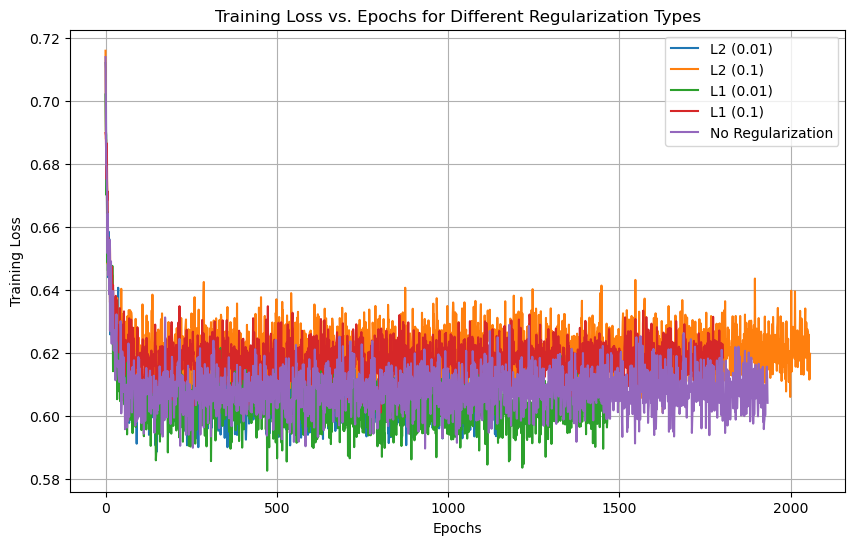

In [103]:
plt.figure(figsize=(10, 6))
for i, losses in enumerate(val_loss_results):
    plt.plot(losses, label=labels[i])

plt.title('Training Loss vs. Epochs for Different Regularization Types')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.grid(True)
plt.show()